## Imports

In [136]:
# import matplotlib
# matplotlib.use('Qt5Agg')  # Set the backend to a valid option like 'TkAgg'
import matplotlib.pyplot as plt
import os
# print(os.environ.get('MPLBACKEND'))
import numpy as np
from PIL import Image
import time
import pandas as pd
import math

In [137]:
def abrirImagenesEscaladas( carpeta, escala=32 ):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            if file.endswith('DS_Store'):
                continue
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [138]:
# Data
if(True):
    img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/')
    img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/') # NO FUNCIONA :(
    img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/')
    img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/')

    data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)


Optimizar los parametros de la funcion f para el conjunto de datos de entrenamiento.

In [139]:
def balancear_datos(imagenes_entrenamiento):

    img_train_sin_neumonia = imagenes_entrenamiento[0]
    img_train_neumonia =imagenes_entrenamiento[1]
    img_test_sin_neumonia =imagenes_entrenamiento[2]
    img_test_neumonia = imagenes_entrenamiento[3]

    # MAX NUMBER OF IMAGES
    n_train = min(len(img_train_sin_neumonia), len(img_train_neumonia))
    n_test = min(len(img_test_sin_neumonia), len(img_test_neumonia))

    # BALANCE
    img_train_sin_neumonia = img_train_sin_neumonia[:n_train]
    img_train_neumonia = img_train_neumonia[:n_train]
    img_test_sin_neumonia = img_test_sin_neumonia[:n_test]
    img_test_neumonia = img_test_neumonia[:n_test]

    
    return (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)

In [140]:
data = balancear_datos(data)

In [141]:
train_sin, train_con, test_sin, test_con = data
training_data = (train_sin,train_con)
testing_data = (test_sin,test_con)

## Ejercicio 1: Derivadas Parciales

Derivada con respecto a $\mathbf{w}$:

$
\frac{\partial L}{\partial \mathbf{w}} = \sum_{i=1}^{N} \left( \left(1 + \tanh(\mathbf{w} \cdot \mathbf{i} + b)\right)^2 - d_i \right) \left(1 - \tanh^2(\mathbf{w} \cdot \mathbf{i} + b)\right) \mathbf{i}
$

Derivada con respecto a $b$:

$
\frac{\partial L}{\partial b} = \sum_{i=1}^{N} \left( \left(1 + \tanh(\mathbf{w} \cdot \mathbf{i} + b)\right)^2 - d_i \right) \left(1 - \tanh^2(\mathbf{w} \cdot \mathbf{i} + b)\right)
$



In [142]:
def L_w(i,w,b,d):
    """Derivada de L con respecto a W

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Vector: Gradiente de la probabilidad con respecto a los pesos
    """
    # t0=tanh(b+W⊤⋅i)
    #return: (1−t0^2)⋅((1+t0)/2−d)⋅i
    
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d) * i



In [143]:
def L_b(i,w,b,d):
    """Derivada de l con respecto a b 

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Float: Gradiente de la probabilidad con respecto al bias
    """
    #t0=tanh(b+W⊤⋅i)
    #(1−t0^2)⋅((1+t0)/2−d)   
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d)



In [144]:
def F(i,w,b):
    """Funcion tanh 

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        probabolidad: 0 < p < 1: Probabilidad de que la imagen sea un 1 (Tiene neumonia)
    """
    tan = np.tanh(np.dot(w,i)+b)
    return (tan + 1)/2

In [145]:
def error_cuadratico(data,w_res, b_res):
    error = 0
    len_data = len(data[0]) + len(data[1])     
                
    # Testing con imágenes sin neumonía
    label = 0
    for i in data[0]: 
        error += (F(i,w_res, b_res) - label)**2 

    # Testing con imágenes con neumonía
    label = 1
    for i in data[1]:
        error += (F(i,w_res, b_res) - label)**2 
    
    return error/len_data

## Ejercicio 2

Implementar el metodo de descenso por gradiente.

In [146]:
def descenso_gradiente(w,b,gradiente_w, gradiente_b, alpha):
    """Calcula el descenso por gradiente de w y b 

    Args:
        imagenes_entrenamiento (List): Lista de imagenes de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate

    Returns:
        Tuple: Pesos y bias actualizados

    """
 
    w = w - alpha * gradiente_w
    b = b - alpha * gradiente_b
    return w,b


## Ejercicio 3

Calcular el error cuadratico durante la optimizacion para el conjunto de entrenamiento y para el conjunto de testing. Generar las visualizaciones correspondientes.

MSE: $ =
\frac{1}{N} \sum_{i=1}^{N} \left( y - \hat{y} \right)^2
$

In [147]:
def train(datos, alpha=0.005, epochs = 5,seed = 42,plot_graph=True):
    """Metodo de entrenamiento atraves del descanso de gradiente por la funcion tanh

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
        
    datos_sin_neumonia = np.array(datos[0])
    datos_con_neumonia = np.array(datos[1])

    # inicioamos con pesos aleatorios
    # set numpy seed
    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0]) * 0.01
    b = np.random.randn(1) * 0.01
   
    len_data = len(datos_sin_neumonia) + len(datos_con_neumonia)
   
    errores = []
   
    
    for epoch in range(epochs):  
        
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
       
            
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 
        
        # Promediar los gradientes acumulados
        gradiente_w /= (len_data)
        gradiente_b /= (len_data)
        
        # Actualización de los parámetros
        w, b = descenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        error_cuadratico = error/len_data
        
        # Almacenar el error cuadrático promedio para visualización
        errores.append(error_cuadratico)
          
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        # Mostrar el error de la epoch actual
        print(f"\rError Cuadratico: {error_cuadratico}",end='',)
    
    if plot_graph:
        plt.plot(errores)
        plt.xlabel('Epoch')
        plt.ylabel('Error Cuadrático')
        plt.title('Error Cuadrático durante el Entrenamiento')
        plt.show()

    return w,b

In [148]:
def test_model(w,b,datos):
    """ Devuelve el porcentaje de de imagenes correctas que clasifico la funcion encontrada
    
    Args:
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 

    Returns:
        Float: Accuracy
    """
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    correctos = 0
    
    for i in datos_sin_neumonia:
        if F(i,w,b) < 0.5:
            correctos += 1
            
    for i in datos_con_neumonia:
        if F(i,w,b) >= 0.5:
            correctos += 1
            
    return correctos/(len(datos_sin_neumonia)+len(datos_con_neumonia))

Error Cuadratico: [0.14362207]

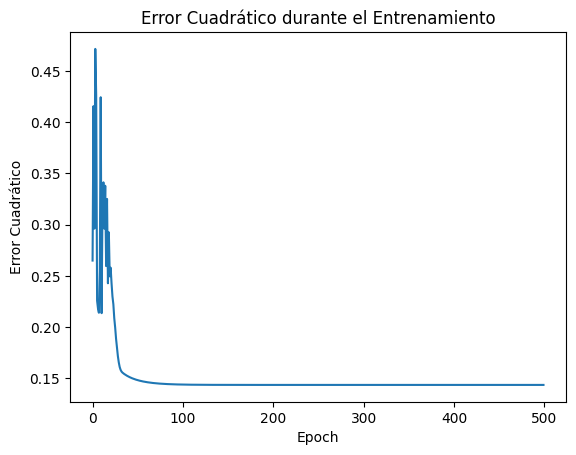

Procentaje de datos correctos: 0.885470719051149%


In [149]:
# Training Data: nos devuelve el w y b munimo, con alpha 0.05 para probar
w_res, b_res = train(
    training_data,
    alpha=0.05,
    epochs = 500,
    seed = 42,
    plot_graph=True
    )

print(f"Procentaje de datos correctos: {test_model(w_res,b_res,training_data)}%")

In [150]:
# Testing Data: calculamos el error cuadratico con los w y b resultantes del training
error_total = error_cuadratico(testing_data,w_res,b_res)
    
print(f"Error cuadratico datos test: {error_total}")
print(f"Procentaje de datos correctos: {test_model(w_res,b_res,testing_data)}%")

Error cuadratico: [0.17524193]
Procentaje de datos correctos: 0.811965811965812%


## Ejercicio 4
Analizar el impacto del parametro α en la convergencia del metodo. Tomar un rango
de 5 valores posibles y analizar la convergencia para el conjunto de testing para los distintos valores de α.

In [151]:
def analizar_convergencia(errores):
    if len(errores) < 2:
        return 1
    return abs(errores[-1] - errores[-2]) 


In [152]:
def train_test_convergencia(datos, alpha,seed,diferencia_minima, plot_graph=True):
    """Usamos el mismo test de antes pero ahora probamos convergencia 

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
       
    datos_sin_neumonia = np.array(datos[0])
    datos_con_neumonia = np.array(datos[1])

    # inicioamos con pesos aleatorios
    # set numpy seed
    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0]) * 0.01
    b = np.random.randn(1) * 0.01
   
    len_data = len(datos_sin_neumonia) + len(datos_con_neumonia)
   
    errores = []
    contador = 0
    
    while(True):  
        
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
       
            
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
        
        # Promediar los gradientes acumulados
        gradiente_w /= (len_data)
        gradiente_b /= (len_data)
        
        # Actualización de los parámetros
        w, b = descenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
        error_cuadratico = error/len_data
        
        # Almacenar el error cuadrático promedio para visualización
        errores.append(error_cuadratico)
          
        
        diferencia = analizar_convergencia(errores)
        
        # Mostrar el error de la epoch actual
        print(f"\rError: {errores[-1]}  Diferencia: {diferencia}",end='',)
        
        if diferencia < diferencia_minima:
            print(f"\nConvergio en el epoch: {contador} con aplha: {alpha}")
            break
        # Mostrar el error de la epoch actual
        # print(f"\rError: {errores[-1]}  Diferencia: {np.linalg.norm(gradiente_w)}",end='',)
        
       
        # if  np.linalg.norm(gradiente_w)  < diferencia_minima:
        #     print(f"\nConvergio en el epoch: {contador} con aplha: {alpha}")
        #     break
        
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        contador += 1
       
        
    if plot_graph:
        plt.plot(errores)
        plt.xlabel('Epoch')
        plt.ylabel('Error Cuadrático')
        plt.title('Error Cuadrático durante el Entrenamiento')
        plt.show()

    return w,b,contador,alpha,errores[-1]

In [153]:
#Testing: Probamos con varios alphas para probar convergencia
# alphas = [ 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
# alphas = [ 0.5, 0.25, 0.125, 0.1, 0.05,0.025,0.0125, 0.01]
alphas = [0.01, 0.05, 0.1, 0.133, 0.143]
# alphas = [ 0.1, 0.111, 0.1195, 0.128, 0.1365, 0.143, 0.154, 0.15675, 0.1595, 0.16225, 0.165]

tiempo_ejecucion = []
epochs = []
alphas_nuevos_valores = []
error_cuadratico_training = []
porcentaje_correctitud_training = []
resultados_w_b = []


for i in alphas:
    
    start_time = time.time()
    
    w_res, b_res, epoch, alpha, error_cuadratico_t = train_test_convergencia(
        training_data,
        alpha=i,
        seed = 42,
        diferencia_minima =  1e-15,
        plot_graph=False
        )
    
    end_time = time.time()
    
    resultados_w_b.append((w_res,b_res))
    tiempo_ejecucion.append(end_time - start_time)
    epochs.append(epoch)
    alphas_nuevos_valores.append(alpha)
    error_cuadratico_training.append(error_cuadratico_t)
    porcentaje_correctitud_training.append(test_model(w_res,b_res,training_data))
    

Error: [0.21040729]  Diferencia: [8.32667268e-16]
Convergio en el epoch: 553 con aplha: 4.7990328719717165e-15
Error: [0.14362207]  Diferencia: [9.71445147e-16]
Convergio en el epoch: 559 con aplha: 1.7638650735146048e-14
Error: [0.14302411]  Diferencia: [9.15933995e-16]
Convergio en el epoch: 574 con aplha: 1.6343664394888096e-14
Error: [0.13269598]  Diferencia: [9.99200722e-16]
Convergio en el epoch: 573 con aplha: 2.2881130152843326e-14
Error: [0.12608717]  Diferencia: [6.9388939e-16]]
Convergio en el epoch: 571 con aplha: 2.7259297372433296e-14


In [154]:
# Testing Data: calculamos el error cuadratico con los w y b resultantes del training para todos los alphas
errores_alphas = []
test_efectividad = []

for w_res,b_res in resultados_w_b:
    error = error_cuadratico(testing_data, w_res,b_res)
    errores_alphas.append(error)
    test_efectividad.append(test_model(w_res,b_res,testing_data))

    

In [155]:
print(alphas)
print(porcentaje_correctitud_training)
print(error_cuadratico_training)

differences_error = [pc - te for pc, te in zip(error_cuadratico_training, errores_alphas)]
print(differences_error)

differences_por = [pc - te for pc, te in zip(porcentaje_correctitud_training, test_efectividad)]
print(differences_por)

print(min(differences_por), max(differences_por))


[0.01, 0.05, 0.1, 0.133, 0.143]
[0.8762045959970348, 0.885470719051149, 0.8843587842846553, 0.882876204595997, 0.882876204595997]
[array([0.21040729]), array([0.14362207]), array([0.14302411]), array([0.13269598]), array([0.12608717])]
[array([-0.01327568]), array([-0.03161986]), array([-0.03095372]), array([-0.03394079]), array([-0.03577067])]
[0.08560630539874425, 0.07350490708533708, 0.07025622018209121, 0.0666368883566808, 0.06877364049343293]
0.0666368883566808 0.08560630539874425


### Graficos de training

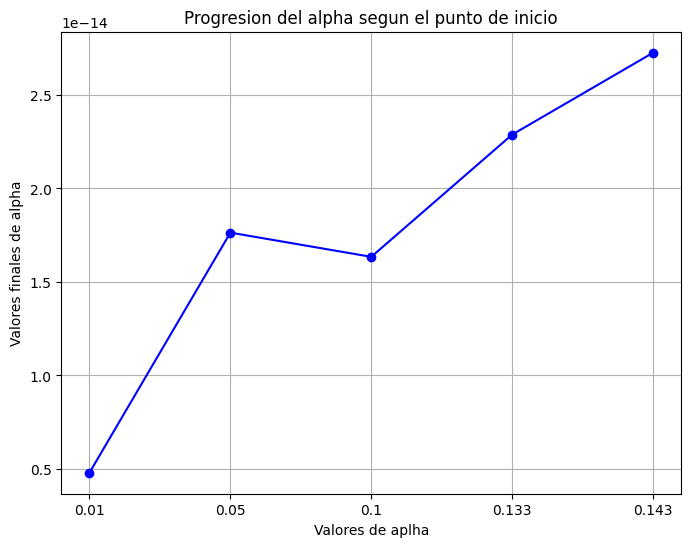

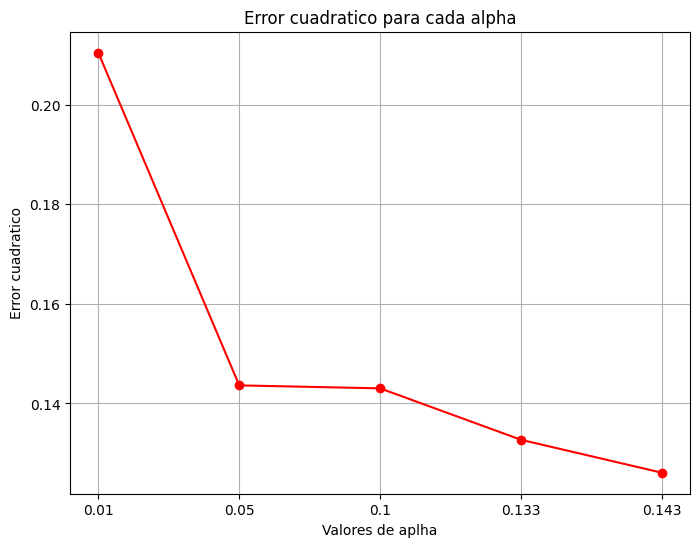

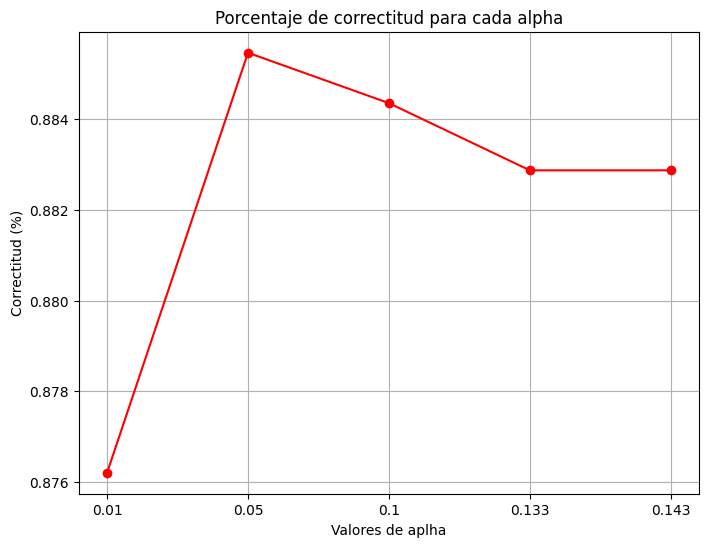

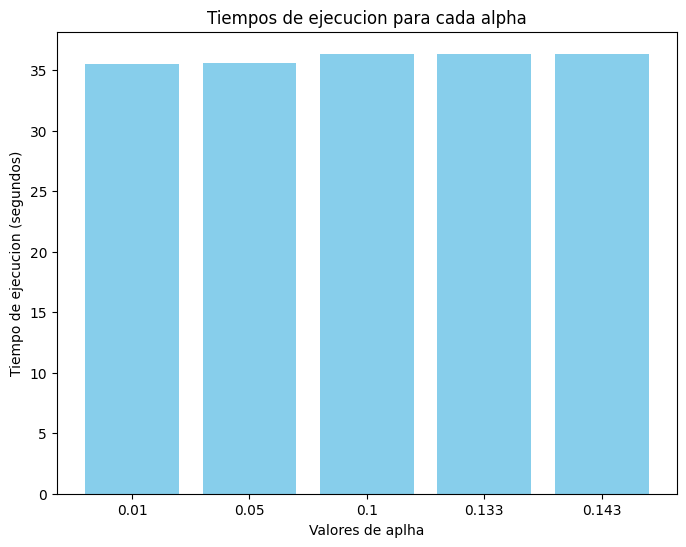

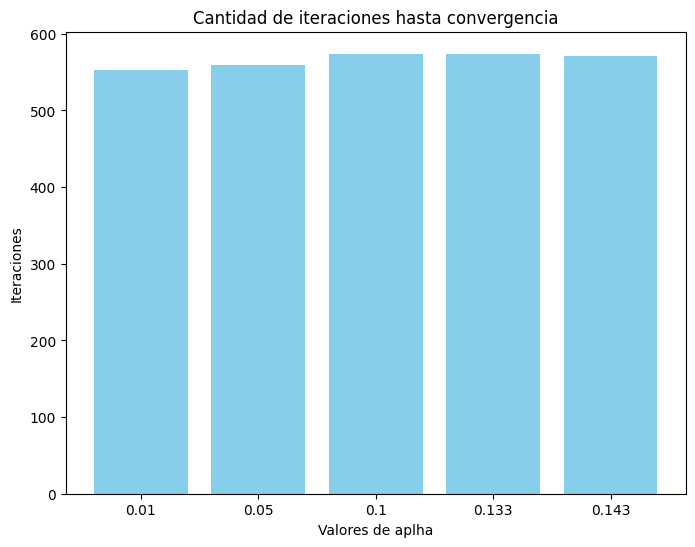

In [156]:
alphas_str = [str(round(alpha,3)) for alpha in alphas]

plt.figure(figsize=(8, 6))

#Progresion del alpha segun el punto de inicio
plt.plot(alphas_str, alphas_nuevos_valores, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Valores finales de alpha')
plt.title('Progresion del alpha segun el punto de inicio')

plt.grid(True) 
plt.show()
plt.figure(figsize=(8, 6))

#Como los valores de alpha influyen al error
plt.plot(alphas_str, error_cuadratico_training, marker='o', linestyle='-', color='r')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Error cuadratico')
plt.title('Error cuadratico para cada alpha')

plt.grid(True) 
plt.show()
plt.figure(figsize=(8, 6))

#Como los valores de alpha influyen al porcentaje de correctitud
plt.plot(alphas_str, porcentaje_correctitud_training, marker='o', linestyle='-', color='r')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Correctitud (%)')
plt.title('Porcentaje de correctitud para cada alpha')

plt.grid(True) 
plt.show()

#Tiempos de ejecucion para cada alpha

plt.figure(figsize=(8, 6))

plt.bar(alphas_str, tiempo_ejecucion, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Tiempo de ejecucion (segundos)')
plt.title('Tiempos de ejecucion para cada alpha')

plt.show()

#Cantidad de iteraciones hasta convergencia
plt.figure(figsize=(8, 6))

plt.bar(alphas_str, epochs, color='skyblue')

plt.xlabel('Valores de aplha')
plt.ylabel('Iteraciones')
plt.title('Cantidad de iteraciones hasta convergencia')

plt.show()

### Graficos de training

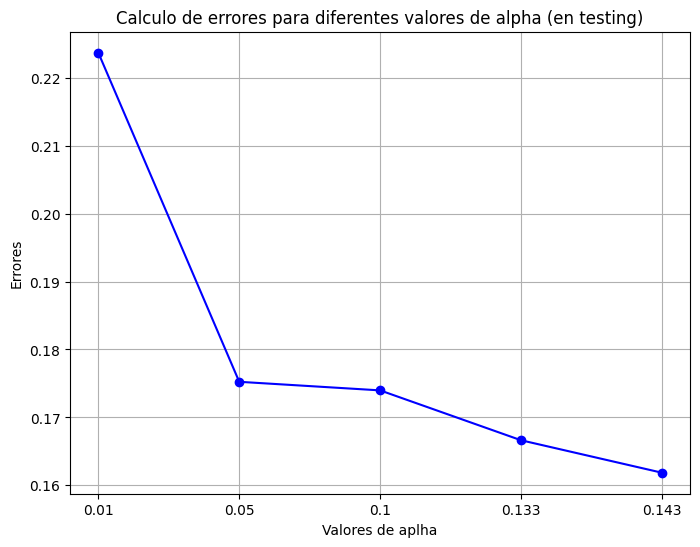

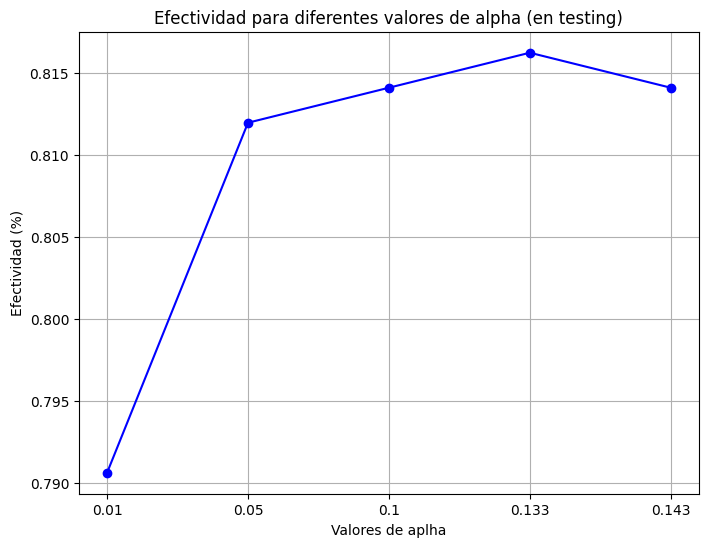

In [157]:

plt.figure(figsize=(8, 6))
plt.plot(alphas_str, errores_alphas, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Errores')
plt.title('Calculo de errores para diferentes valores de alpha (en testing)')

plt.grid(True) 
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(alphas_str, test_efectividad, marker='o', linestyle='-', color='b')  # Gráfico de líneas

plt.xlabel('Valores de aplha')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad para diferentes valores de alpha (en testing)')

plt.grid(True) 
plt.show()

El mejor valor de alpha es 0.133

## Ejercicio 5

¿Como impacta el tamaño del escalado de las imagenes en la efectividad del metodo? ¿Y en el tiempo de computo?. Realizar los experimentos y graficos acordes para estudiar estas limitaciones.

In [158]:
def probar_escalados(esclados):
    tiempo_ejecucion_esclado = []
    efectividad_training = []
    efectividad_testing = []
    errors_escalado = []

    for i,alpha in esclados:
        img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/',i)
        img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/',i) 
        img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/',i)
        img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/',i)

        data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)
        
        data = balancear_datos(data)
        
        img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia= data
        training_img_data = (img_train_sin_neumonia, img_train_neumonia)
        testing_img_data = (img_test_sin_neumonia, img_test_neumonia)
        
        print("Data is imported")
        
        start_time = time.time()
        
        w_res, b_res, _ ,__,___ = train_test_convergencia(
            training_img_data,
            alpha=alpha,
            # epochs=600,
            seed = 42,
            diferencia_minima=1e-15,
            plot_graph=False
            )
        
        end_time = time.time()
        
        tiempo_ejecucion_esclado.append(end_time - start_time)
        efectividad_training.append(test_model(w_res,b_res,training_img_data))
        
        efectividad_testing.append(test_model(w_res,b_res,testing_img_data))
        errors_escalado.append(error_cuadratico(testing_img_data,w_res,b_res))
    
    return tiempo_ejecucion_esclado,efectividad_testing,efectividad_training,errors_escalado
    

In [170]:
esclados_con_alpha = [(8,0.133),(16,0.133),(32,0.133),(64,0.0133),(96,0.0133),(112,0.0133),(128,0.0133),(256,0.013),(512,0.00133)]
esclados = [8,16,32,64,96,112,128,256,512]
tiempo_ejecucion_esclado,efectividad_testing,efectividad_training,errors_escalado = probar_escalados(esclados_con_alpha)

Data is imported
Error: [0.22917643]  Diferencia: [9.71445147e-16]
Convergio en el epoch: 539 con aplha: 1.3088048378652458e-13
Data is imported
Error: [0.16439814]  Diferencia: [7.77156117e-16]
Convergio en el epoch: 560 con aplha: 4.457287040771406e-14
Data is imported
Error: [0.13269598]  Diferencia: [9.99200722e-16]
Convergio en el epoch: 573 con aplha: 2.2881130152843326e-14
Data is imported
Error: [0.13940192]  Diferencia: [9.99200722e-16]
Convergio en el epoch: 556 con aplha: 5.472379175446982e-15
Data is imported
Error: [0.14348349]  Diferencia: [9.99200722e-16]
Convergio en el epoch: 577 con aplha: 1.8636823516554368e-15
Data is imported
Error: [0.49999925]  Diferencia: [9.99200722e-16]
Convergio en el epoch: 214 con aplha: 2.2735430013518743e-07
Data is imported
Error: [0.49999867]  Diferencia: [9.99200722e-16]
Convergio en el epoch: 243 con aplha: 5.136741679802968e-08
Data is imported
Error: [0.5]  Diferencia: [0.]6220612]
Convergio en el epoch: 2 con aplha: 0.0117324999999

### Graficos

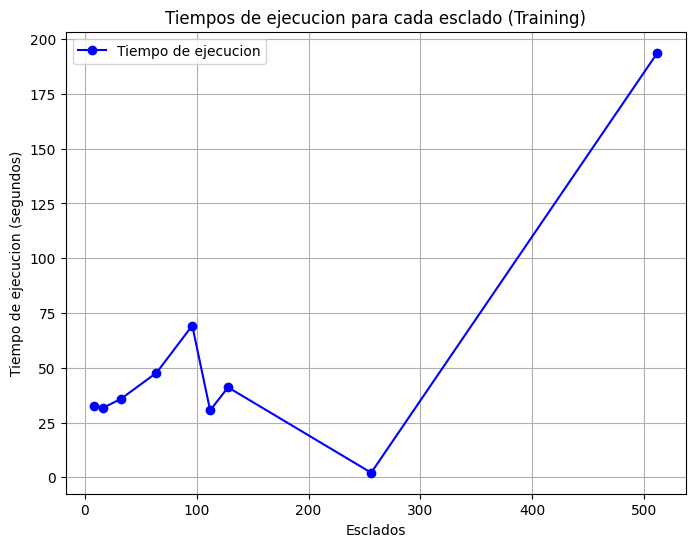

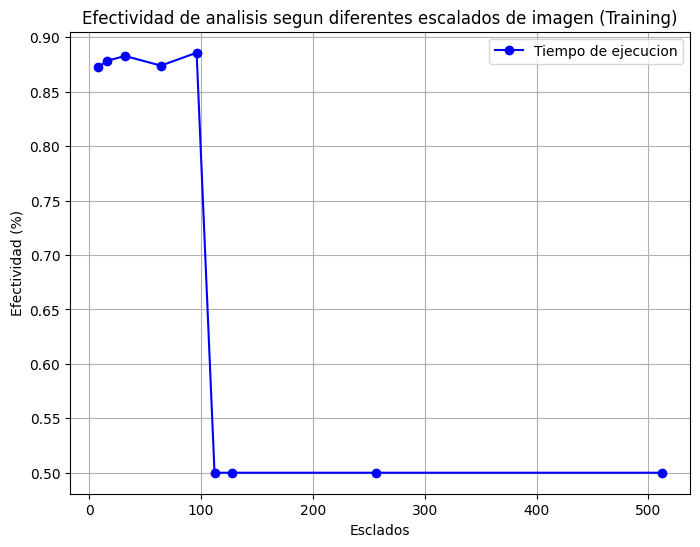

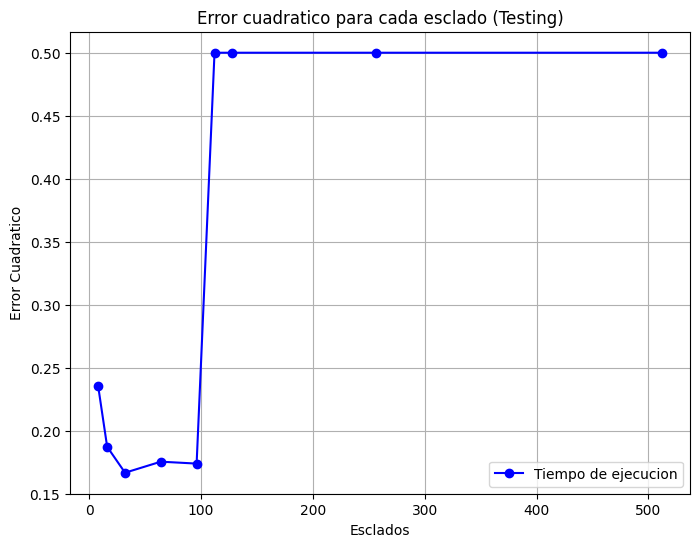

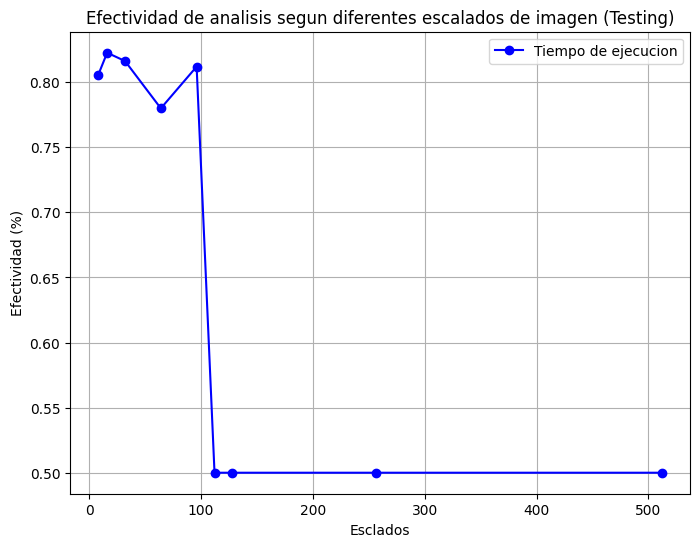

In [171]:

### graficos training
#Tiempos de ejecucion para cada esclado
plt.figure(figsize=(8, 6))

plt.plot(esclados, tiempo_ejecucion_esclado, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Tiempo de ejecucion (segundos)')
plt.title('Tiempos de ejecucion para cada esclado (Training)')
plt.legend()  
plt.grid(True) 
plt.show()

#Efectividad para el escalado
plt.figure(figsize=(8, 6))

plt.plot(esclados, efectividad_training, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad de analisis segun diferentes escalados de imagen (Training)')
plt.legend()  
plt.grid(True) 
plt.show()

#### Graficos testing
#errors para el escalado
plt.figure(figsize=(8, 6))

plt.plot(esclados, errors_escalado, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Error Cuadratico')
plt.title('Error cuadratico para cada esclado (Testing)')
plt.legend()  
plt.grid(True) 
plt.show()

#Efectividad para el escalado
plt.figure(figsize=(8, 6))

plt.plot(esclados, efectividad_testing, marker='o', linestyle='-', color='b', label='Tiempo de ejecucion')  # Gráfico de líneas

plt.xlabel('Esclados')
plt.ylabel('Efectividad (%)')
plt.title('Efectividad de analisis segun diferentes escalados de imagen (Testing)')
plt.legend()  
plt.grid(True) 
plt.show()

## Ejercicio 6 

Para el valor de α que tenga mejor valor de convergencia, generar la matriz de confusion y analizar brevemente la efectividad del metodo.

In [161]:
def matriz_de_confusion(datos, w, b):
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    len_datos = len(datos_sin_neumonia) + len(datos_con_neumonia)
    
    Verdadero_Positivo = 0
    Falso_Negativo = 0
    Verdadero_Negativo = 0
    Falso_Positivo = 0
    
    for i in datos_sin_neumonia:
        if F(i,w,b) < 0.5:
            Verdadero_Negativo += 1
        else:
            Falso_Positivo += 1
            
    for i in datos_con_neumonia:
        if F(i,w,b) >= 0.5:
            Verdadero_Positivo += 1
        else:
            Falso_Negativo += 1
            
    matriz = [[Verdadero_Positivo/len_datos , Falso_Negativo/len_datos],
              [Falso_Positivo/len_datos , Verdadero_Negativo/len_datos]]
    
    return matriz
    

In [162]:
w_res, b_res = train(
    training_data,
    alpha=0.133,
    epochs = 500,
    seed = 42,
    plot_graph=False
    )

matriz_de_confusion_training = matriz_de_confusion(training_data,w_res, b_res)
matriz_de_confusion_testing = matriz_de_confusion(testing_data,w_res, b_res)

Error Cuadratico: [0.13269598]

In [163]:
print(f"True Positive  | False negative")
print("--------------------------------")
print(f"False positive | True negative\n")

print(f"Training: {matriz_de_confusion_training[:1]}\n")
print(f"          {matriz_de_confusion_training[1:]}\n")
print(f"Testing: {matriz_de_confusion_testing[:1]}\n")
print(f"         {matriz_de_confusion_testing[1:]}")

True Positive  | False negative
--------------------------------
False positive | True negative

Training: [[0.4406968124536694, 0.05930318754633061]]

          [[0.05782060785767235, 0.44217939214232765]]

Testing: [[0.43162393162393164, 0.06837606837606838]]

         [[0.11538461538461539, 0.38461538461538464]]
